# Testing the Models on the IDS-2018 Dataset

In this notebook, the IDS-2018 dataset is loaded and the models trained on the IDS 2017 are tested to check for generalization

This command was used to download the csv files from the ids 2018 dataset: 
`aws s3 sync --no-sign-request --region us-east-2 "s3://cse-cic-ids2018/" "C:\Users\youss\Downloads" --exclude "*" --include "*.csv"`

## 1. Preprocessing

In [1]:
import numpy as np
import pandas as pd
import os
import re
from notebook_utils import load_processed_dataset_2017, plot_confusion_matrix, metrics_report
from keras.models import load_model as keras_load_model
%matplotlib inline
%load_ext autoreload
%autoreload 2
import gc
    
file_path = r"CIC-IDS-2018\Processed Traffic Data for ML Algorithms"
file_path_2017 = r"CIC-IDS-2017\CSVs\GeneratedLabelledFlows\TrafficLabelling\processed\ids2017_processed.csv"
# Load the scaler from the 2017 dataset
X_train, Y_train, X_eval, Y_eval, X_test, Y_test, scaler = load_processed_dataset_2017(file_path_2017)
gc.collect()

14

In [2]:
import numpy as np
import pandas as pd
import os
import re
import gc

# Define the regular expression to match spaces and special characters
column_name_regex = re.compile(r'[^\w\s]')

# Function to trim column names
def trim_column_names(df):
    df.columns = [column_name_regex.sub('_', c.lower()) for c in df.columns]
    return df

# Initialize an empty list to hold the sampled DataFrames
df_list = []

# Fraction to sample
sampling_fraction = 0.1

# Iterate over all CSV files in the folder
for i, file_name in enumerate(os.listdir(file_path)):
    if file_name.endswith(".csv"):
        file_full_path = os.path.join(file_path, file_name)
        # Read the CSV file in chunks
        for chunk in pd.read_csv(file_full_path, chunksize=100000, low_memory=False):
            # Sample the chunk
            sampled_chunk = chunk.sample(frac=sampling_fraction, random_state=1)
            df_list.append(sampled_chunk)
            # Delete chunk to free memory
            del chunk
        # Print progress
        print(f"Processed {i+1}/{len(os.listdir(file_path))} files.")

# Concatenate the sampled DataFrames
combined_df = pd.concat(df_list, ignore_index=True)

# Apply the function to the column names
combined_df = trim_column_names(combined_df)

# Delete the list of DataFrames to free memory
del df_list
gc.collect()

# Print DataFrame info
print(combined_df.info())

Processed 1/10 files.
Processed 2/10 files.
Processed 3/10 files.
Processed 4/10 files.
Processed 5/10 files.
Processed 6/10 files.
Processed 7/10 files.
Processed 8/10 files.
Processed 9/10 files.
Processed 10/10 files.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1623303 entries, 0 to 1623302
Data columns (total 84 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   dst port           1623303 non-null  object 
 1   protocol           1623303 non-null  object 
 2   timestamp          1623303 non-null  object 
 3   flow duration      1623303 non-null  object 
 4   tot fwd pkts       1623303 non-null  object 
 5   tot bwd pkts       1623303 non-null  object 
 6   totlen fwd pkts    1623303 non-null  object 
 7   totlen bwd pkts    1623303 non-null  object 
 8   fwd pkt len max    1623303 non-null  object 
 9   fwd pkt len min    1623303 non-null  object 
 10  fwd pkt len mean   1623303 non-null  object 
 11  fwd pkt len

In [3]:
def replace_spaces_in_column_names(df):
    df.columns = [c.replace(' ', '_').lower() for c in df.columns]
    return df
combined_df = replace_spaces_in_column_names(combined_df)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1623303 entries, 0 to 1623302
Data columns (total 84 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   dst_port           1623303 non-null  object 
 1   protocol           1623303 non-null  object 
 2   timestamp          1623303 non-null  object 
 3   flow_duration      1623303 non-null  object 
 4   tot_fwd_pkts       1623303 non-null  object 
 5   tot_bwd_pkts       1623303 non-null  object 
 6   totlen_fwd_pkts    1623303 non-null  object 
 7   totlen_bwd_pkts    1623303 non-null  object 
 8   fwd_pkt_len_max    1623303 non-null  object 
 9   fwd_pkt_len_min    1623303 non-null  object 
 10  fwd_pkt_len_mean   1623303 non-null  object 
 11  fwd_pkt_len_std    1623303 non-null  object 
 12  bwd_pkt_len_max    1623303 non-null  object 
 13  bwd_pkt_len_min    1623303 non-null  object 
 14  bwd_pkt_len_mean   1623303 non-null  object 
 15  bwd_pkt_len_std    1623303 non-n

In [4]:
print("Mapping columns to match the trained features...")
# Map columns to match the trained features
column_mapping = {
    'protocol': 'protocol',
    'flow_duration': 'flow_duration',
    'tot_fwd_pkts': 'total_fwd_packets',
    'totlen_fwd_pkts': 'total_length_of_fwd_packets',
    'fwd_pkt_len_max': 'fwd_packet_length_max',
    'fwd_pkt_len_min': 'fwd_packet_length_min',
    'fwd_pkt_len_mean': 'fwd_packet_length_mean',
    'bwd_pkt_len_max': 'bwd_packet_length_max',
    'bwd_pkt_len_min': 'bwd_packet_length_min',
    'flow_byts_s': 'flow_bytes_s',
    'flow_pkts_s': 'flow_packets_s',
    'flow_iat_mean': 'flow_iat_mean',
    'flow_iat_std': 'flow_iat_std',
    'flow_iat_min': 'flow_iat_min',
    'fwd_iat_min': 'fwd_iat_min',
    'bwd_iat_tot': 'bwd_iat_total',
    'bwd_iat_mean': 'bwd_iat_mean',
    'bwd_iat_std': 'bwd_iat_std',
    'bwd_iat_max': 'bwd_iat_max',
    'fwd_psh_flags': 'fwd_psh_flags',
    'fwd_urg_flags': 'fwd_urg_flags',
    'fwd_header_len': 'fwd_header_length',
    'bwd_header_len': 'bwd_header_length',
    'bwd_pkts_s': 'bwd_packets_s',
    'pkt_len_min': 'min_packet_length',
    'fin_flag_cnt': 'fin_flag_count',
    'rst_flag_cnt': 'rst_flag_count',
    'psh_flag_cnt': 'psh_flag_count',
    'ack_flag_cnt': 'ack_flag_count',
    'urg_flag_cnt': 'urg_flag_count',
    'down_up_ratio': 'down_up_ratio',
    'init_fwd_win_byts': 'init_win_bytes_forward',
    'init_bwd_win_byts': 'init_win_bytes_backward',
    'fwd_act_data_pkts': 'act_data_pkt_fwd',
    'fwd_seg_size_min': 'min_seg_size_forward',
    'active_mean': 'active_mean',
    'active_std': 'active_std',
    'active_max': 'active_max',
    'idle_std': 'idle_std'
}

print("Renaming columns in the DataFrame...")
# Rename the columns in the new DataFrame to match the trained feature names
combined_df.rename(columns=column_mapping, inplace=True)

# Updated feature columns
feature_columns = list(column_mapping.values())

print("Creating is_attack column...")
# Selecting the necessary columns and creating is_attack
combined_df['is_attack'] = combined_df.label.apply(lambda x: 0 if x == "Benign" else 1)

print("Ensuring the data types are correct...")
# Ensure the data types are correct
combined_df[feature_columns] = combined_df[feature_columns].apply(pd.to_numeric, errors='coerce')

print("Removing rows with null, infinity, and negative values...")
# Remove rows with null, infinity, and negative values
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_df.dropna(subset=feature_columns, inplace=True)
combined_df = combined_df[(combined_df[feature_columns] >= 0).all(axis=1)]

print("Data preprocessing completed.")

Mapping columns to match the trained features...
Renaming columns in the DataFrame...
Creating is_attack column...
Ensuring the data types are correct...
Removing rows with null, infinity, and negative values...
Data preprocessing completed.


In [5]:
combined_df["is_attack"].value_counts()

is_attack
0    670707
1    126692
Name: count, dtype: int64

## 2. Loading and Testing the Modules

In [6]:
# Apply the scaler to the selected columns directly in the DataFrame
# print("Scaling the data...")
# combined_df[feature_columns] = scaler.transform(combined_df[feature_columns])
# Separate features and target
X_new = combined_df[feature_columns]
Y_new = combined_df[['is_attack']]  # Define Y_new as a DataFrame

In [7]:
X_new.head()
X_test.head()

,protocol,flow_duration,total_fwd_packets,total_length_of_fwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,bwd_packet_length_max,bwd_packet_length_min,flow_bytes_s,...,urg_flag_count,down_up_ratio,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,idle_std
456652,17,171.0,2,54.0,27.0,27.0,27.000000,59.0,59.0,1.005848e+06,...,0,1.0,10815.441693,4054.888799,1,32.0,0.0,0.0,0.0,0.0
1298933,6,11796102.0,5,3525.0,3525.0,0.0,705.000000,413.0,0.0,3.338391e+02,...,0,0.0,29200.000000,296.000000,1,32.0,880.0,0.0,880.0,0.0
2653282,6,1717887.0,3,26.0,20.0,0.0,8.666667,4380.0,0.0,6.771691e+03,...,0,2.0,8192.000000,229.000000,2,20.0,0.0,0.0,0.0,0.0
304393,17,61074.0,1,49.0,49.0,49.0,49.000000,79.0,79.0,2.095818e+03,...,0,1.0,10815.441693,4054.888799,0,32.0,0.0,0.0,0.0,0.0
222063,17,32906.0,2,70.0,35.0,35.0,35.000000,63.0,63.0,5.956361e+03,...,0,1.0,10815.441693,4054.888799,1,32.0,0.0,0.0,0.0,0.0


Model loaded from models/id3_model.pkl
Model loaded from models/random_forest.pkl
Model loaded from models/xgb_model.pkl


Keras model loaded from models/DNN_model1.h5
Keras model loaded from models/DNN_model2.keras
Keras model loaded from models/DNN_model1.keras
Evaluating ID3...
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.8378    0.9486    0.8898    670707
           1     0.0921    0.0276    0.0425    126692

    accuracy                         0.8023    797399
   macro avg     0.4649    0.4881    0.4661    797399
weighted avg     0.7193    0.8023    0.7551    797399

Accuracy: 0.8022896943688166


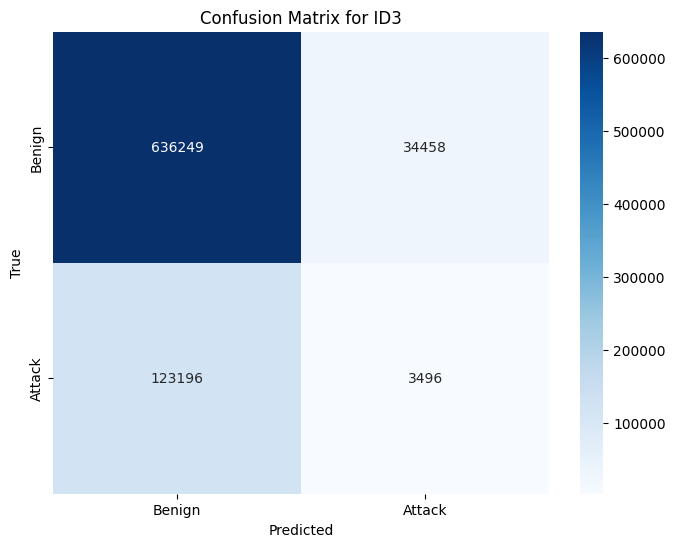

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    1.8s finished


Evaluating Random Forest...
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.8401    0.9880    0.9081    670707
           1     0.0663    0.0045    0.0084    126692

    accuracy                         0.8318    797399
   macro avg     0.4532    0.4963    0.4583    797399
weighted avg     0.7172    0.8318    0.7651    797399

Accuracy: 0.8317592572852487


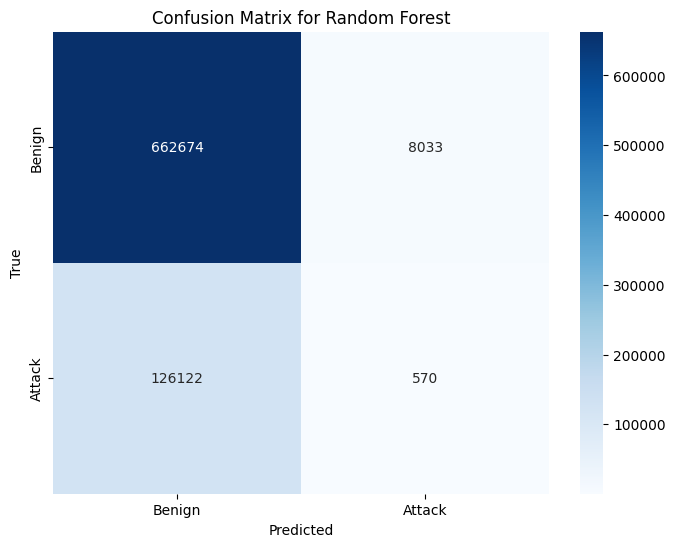

Evaluating XGBoost...
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.8430    0.9953    0.9129    670707
           1     0.4348    0.0190    0.0364    126692

    accuracy                         0.8402    797399
   macro avg     0.6389    0.5072    0.4746    797399
weighted avg     0.7782    0.8402    0.7736    797399

Accuracy: 0.8402129924918391


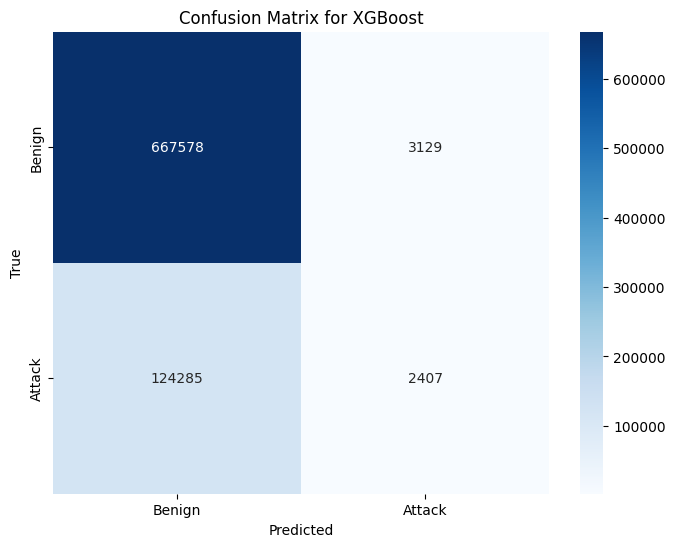

24919/24919 ━━━━━━━━━━━━━━━━━━━━ 11s 418us/step
Evaluating DNN1...
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.8772    0.9404    0.9077    670707
           1     0.4896    0.3028    0.3742    126692

    accuracy                         0.8391    797399
   macro avg     0.6834    0.6216    0.6409    797399
weighted avg     0.8156    0.8391    0.8229    797399

Accuracy: 0.8390843229048444


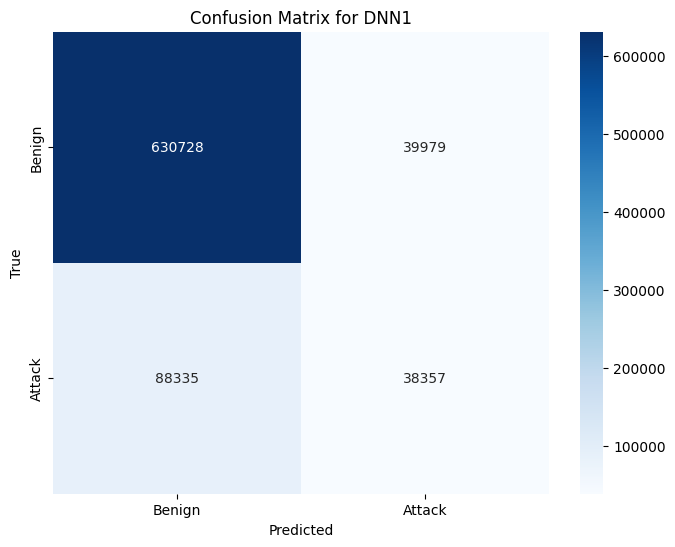

24919/24919 ━━━━━━━━━━━━━━━━━━━━ 11s 430us/step
Evaluating DNN2...
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.8796    0.9100    0.8946    670707
           1     0.4169    0.3407    0.3750    126692

    accuracy                         0.8196    797399
   macro avg     0.6483    0.6253    0.6348    797399
weighted avg     0.8061    0.8196    0.8120    797399

Accuracy: 0.8195545768178791


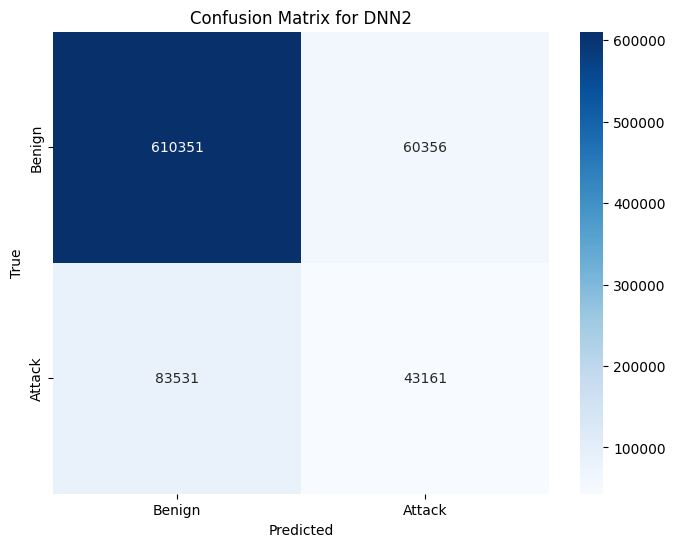

24919/24919 ━━━━━━━━━━━━━━━━━━━━ 18s 738us/step
Evaluating DNN3...
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.8392    0.9470    0.8898    670707
           1     0.1237    0.0396    0.0600    126692

    accuracy                         0.8028    797399
   macro avg     0.4815    0.4933    0.4749    797399
weighted avg     0.7255    0.8028    0.7580    797399

Accuracy: 0.8027988497602832


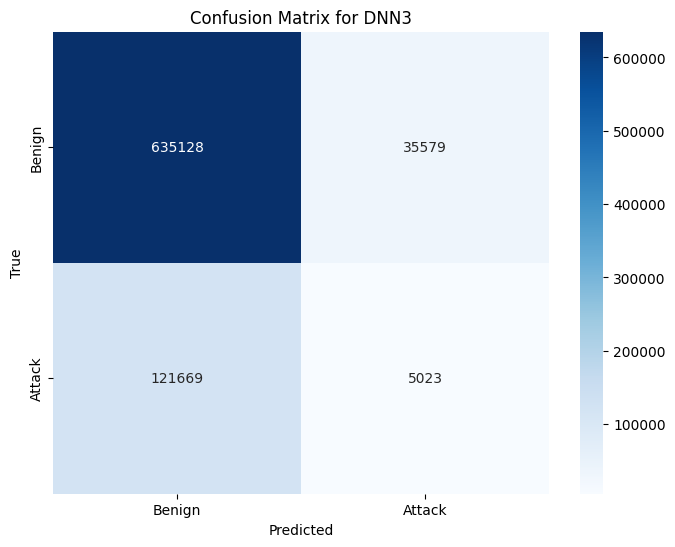

In [8]:
import joblib
from keras.optimizers import Adam
def load_model(model_name):
    file_path = f'models/{model_name}.pkl'
    model = joblib.load(file_path)
    print(f'Model loaded from {file_path}')
    return model

def load_keras_model(model_name):
    file_path = f'models/{model_name}'
    model = keras_load_model(file_path)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    print(f'Keras model loaded from {file_path}')
    return model
# Load the models
models = {
    'ID3': load_model('id3_model'),
    'Random Forest': load_model('random_forest'),
    'XGBoost': load_model('xgb_model'),
    'DNN1': load_keras_model('DNN_model1.h5'),
    'DNN2': load_keras_model('DNN_model2.keras'),
    'DNN3': load_keras_model('DNN_model1.keras')
}

# Evaluate the models on the training data
for model_name, model in models.items():
    if 'DNN' in model_name:
        y_pred_prob = model.predict(scaler.transform(X_new))
        predictions = (y_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions and flatten to 1D array
    else:
        predictions = model.predict(scaler.transform(X_new))
    print(f"Evaluating {model_name}...")
    metrics_report("Evaluation", Y_new.is_attack, predictions, print_avg=False)
    plot_confusion_matrix(model_name, Y_new, predictions)


## Conclusion

Given the results, the models don't generalize very well to the IDS-2018 dataset. Another approach is considered, invloving active learning and semi-supervised learning, using both datasets to train the models.